## Analysing an initial dataset

In [24]:
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pathlib import Path
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = pd.read_csv(Path('../data/writers.csv'))

## Data format

In [6]:
df.columns

Index(['Unnamed: 0', 'AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate',
       'CommentCount', 'CommunityOwnedDate', 'CreationDate', 'FavoriteCount',
       'Id', 'LastActivityDate', 'LastEditDate', 'LastEditorDisplayName',
       'LastEditorUserId', 'OwnerDisplayName', 'OwnerUserId', 'ParentId',
       'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount', 'body_text'],
      dtype='object')

In [7]:
# Start by changing types to make processing easier
df['AnswerCount'] = df['AnswerCount'].fillna(-1)
df['AnswerCount'] = df['AnswerCount'].astype(int)
df['PostTypeId'] = df['PostTypeId'].astype(int)
df['Id'] = df['Id'].astype(int)
df.set_index('Id', inplace=True, drop=False)

# Add measure of the length of a post
df['full_text'] = df['Title'].str.cat(df['body_text'], sep=" ", na_rep="")
df['text_len'] = df['full_text'].str.len()

# A question is a post of id 1
df['is_question'] = df['PostTypeId'] == 1

## Data Quality

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34330 entries, 1 to 42885
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             34330 non-null  int64  
 1   AcceptedAnswerId       4124 non-null   float64
 2   AnswerCount            34330 non-null  int64  
 3   Body                   34256 non-null  object 
 4   ClosedDate             969 non-null    object 
 5   CommentCount           34330 non-null  int64  
 6   CommunityOwnedDate     186 non-null    object 
 7   CreationDate           34330 non-null  object 
 8   FavoriteCount          3307 non-null   float64
 9   Id                     34330 non-null  int64  
 10  LastActivityDate       34330 non-null  object 
 11  LastEditDate           11201 non-null  object 
 12  LastEditorDisplayName  614 non-null    object 
 13  LastEditorUserId       10648 non-null  float64
 14  OwnerDisplayName       1976 non-null   object 
 15  Ow

In [11]:
df = df[df['PostTypeId'].isin([1, 2])]

In [12]:
questions_with_accepted_answers = df[df['is_question'] & ~(df['AcceptedAnswerId'].isna())]
q_and_a = questions_with_accepted_answers.join(df[['body_text']], on='AcceptedAnswerId', how='left', rsuffix='_answer')

# Setting this option allows us to display all the data
pd.options.display.max_colwidth = 500
q_and_a[['body_text', 'body_text_answer']][:3]

,body_text,body_text_answer
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re..."
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","With a story in first person, you are intending the reader to become much more attached to the main character. Since the reader sees what that character sees and feels what that character feels, the reader will have an emotional investment in that character. Third person does not have this close tie; a reader can become emotionally invested but it will not be as strong as it will be in first person.\nContrarily, you cannot have multiple point characters when you use first person without ex..."
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents ..."


In [13]:
df = df.join(df[['Id', 'Title', 'body_text', 'text_len', 'Score', 'AcceptedAnswerId']], on='ParentId', how='left', rsuffix='_question')

## Data quantity and distribution
Now that we have linked questions and answers, let's produce some summary statistics.

In [16]:
has_accepted_answer = df[df['is_question'] & ~(df['AcceptedAnswerId'].isna())]
received_answers = df[df['is_question'] & (df['AnswerCount']!=0)]
no_answers = df[df['is_question'] & (df['AcceptedAnswerId'].isna()) & (df['AnswerCount']==0)]

print("{} total questions \n {} received at least one answer\n {} received an accepted answer".format(
    len(df[df['is_question']]),
    len(received_answers),
    len(has_accepted_answer)))

7971 total questions 
 7827 received at least one answer
 4124 received an accepted answer


Most questions have an answer, and only half of those answers have been accepted. Whether a question received an accepted answer could be a good label.

Another potential label would be the number of upvotes a question received, denoted in the `Score` column. This label is helpful because we can either treat it as a binary (whether the score is higher or lower than the median) or continuous depending on how granular we would like our model to be.

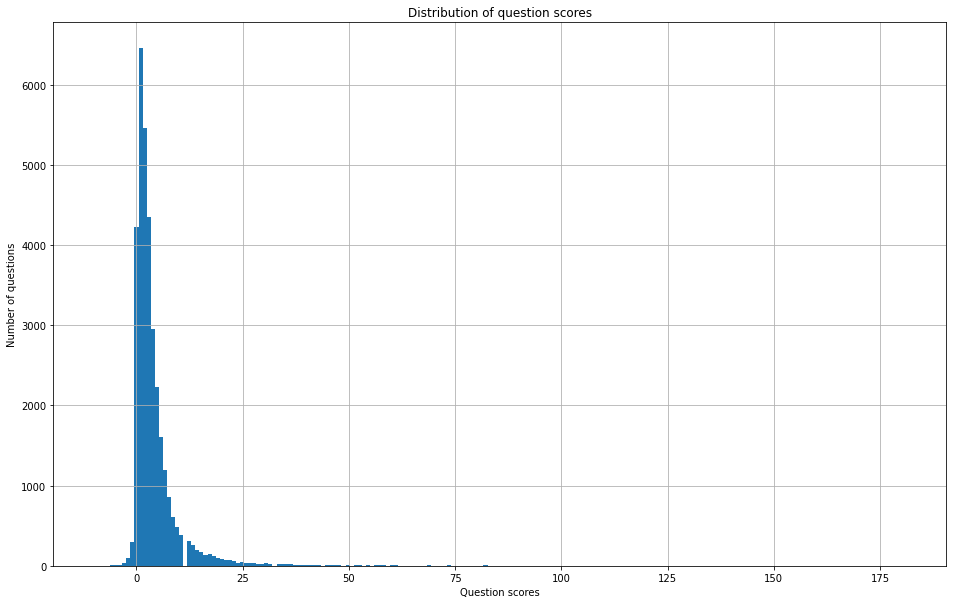

In [18]:
f, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Distribution of question scores')
ax.set_xlabel('Question scores')
ax.set_ylabel('Number of questions')
df['Score'].hist(bins=200, ax=ax)

Let's dive more into the questions by looking at potential predictive features, such as question length. How long are the questions in our dataset?

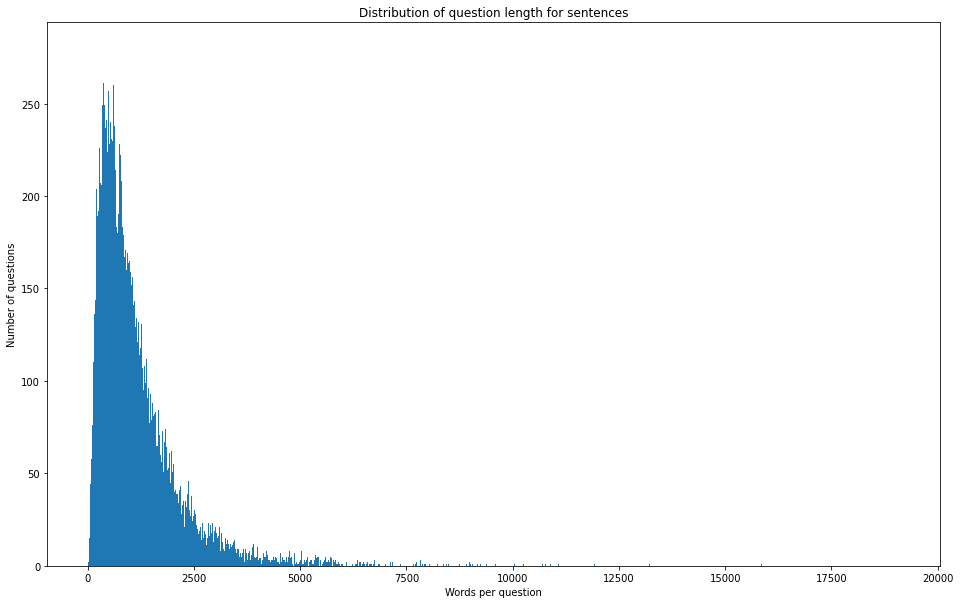

In [19]:
f, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Distribution of question length for sentences')
ax.set_xlabel('Words per question')
ax.set_ylabel('Number of questions')
q_len = plt.hist(df['text_len'], bins=2000, log=False)

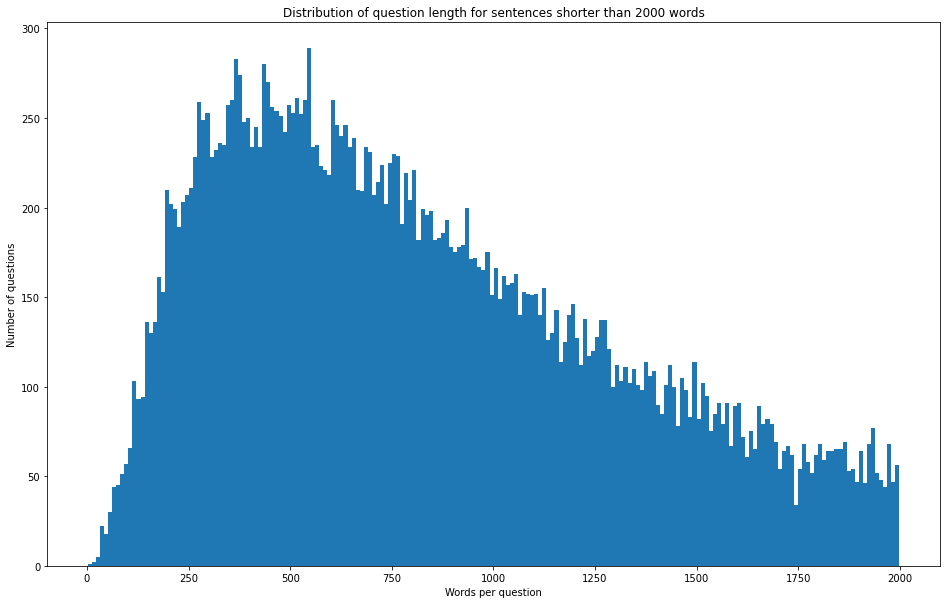

In [22]:
f, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Distribution of question length for sentences shorter than 2000 words')
ax.set_xlabel('Words per question')
ax.set_ylabel('Number of questions')
q_len = plt.hist(df[df['text_len']< 2000]['text_len'], bins=200, log=False)

Is sentence length predictive of getting many upvotes?

In order to start answering this question, we can update this plot to overlay the distributions for both high and low score questions.

Text(0, 0.5, 'Percentage of sentences')

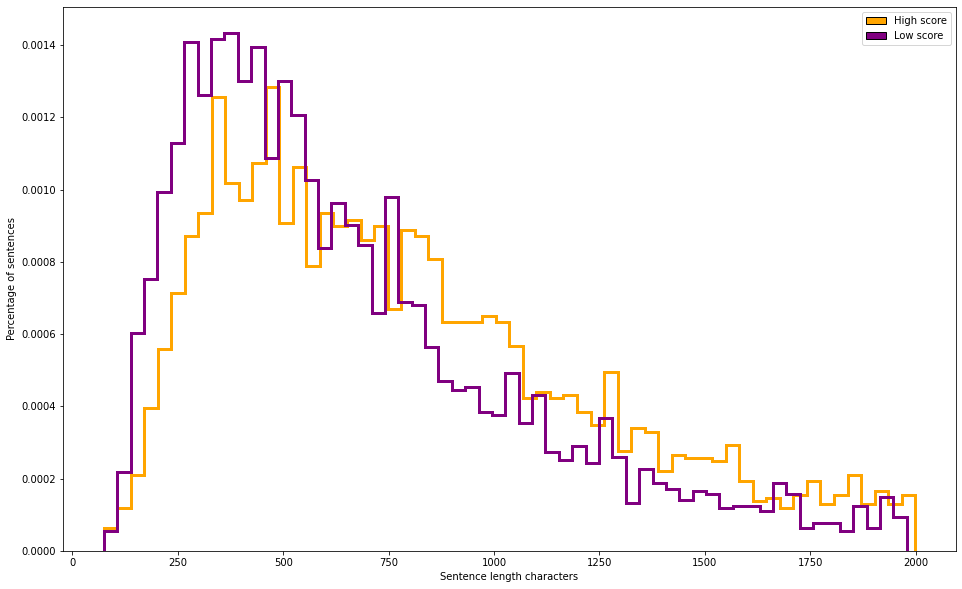

In [25]:
high_score = df['Score'] > df['Score'].median()
# We wilter out really long questions
normal_length = df['text_len'] < 2000

ax = df[df['is_question'] & high_score & normal_length]['text_len'].hist(bins=60,
                                                                        density=True,
                                                                        histtype='step',
                                                                        color='orange',
                                                                        linewidth=3,
                                                                        grid=False,
                                                                        figsize=(16, 10))

df[df['is_question'] & ~high_score & normal_length]['text_len'].hist(bins=60,
                                                                     density=True,
                                                                     histtype='step',
                                                                     color='purple',
                                                                     linewidth=3,
                                                                     grid=False,)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec='k') for c in ['orange', 'purple']
]
labels = ['High score', 'Low score']

plt.legend(handles, labels)
ax.set_xlabel('Sentence length characters')
ax.set_ylabel('Percentage of sentences')

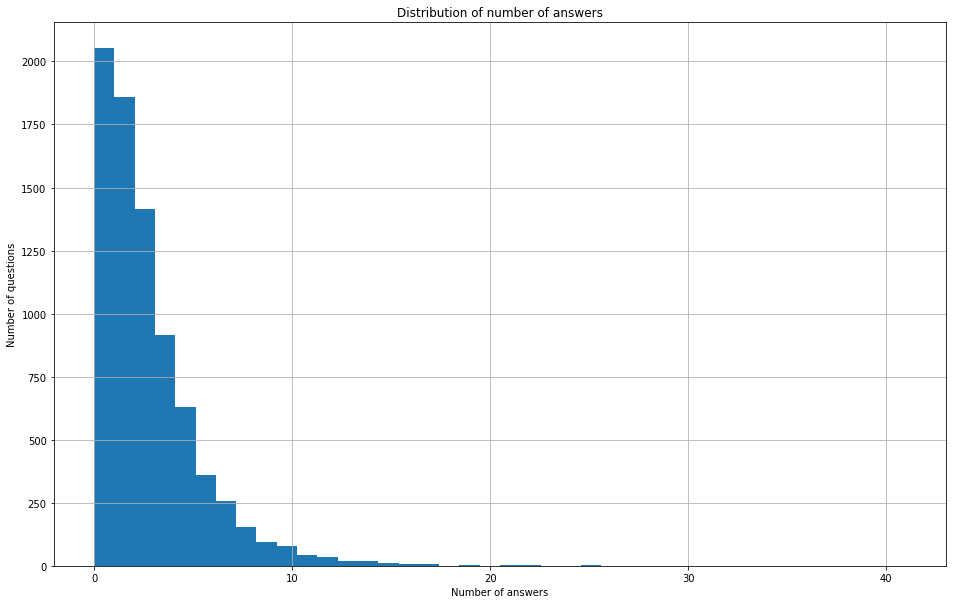

In [31]:
f, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Distribution of number of answers')
ax.set_xlabel('Number of answers')
ax.set_ylabel('Number of questions')
hist = df[df['is_question']]['AnswerCount'].hist(bins=40)

Let's see if questions with high scores tend to get more answers:

First, let's plot one as a function of the other, and see whether we can establish a trend.

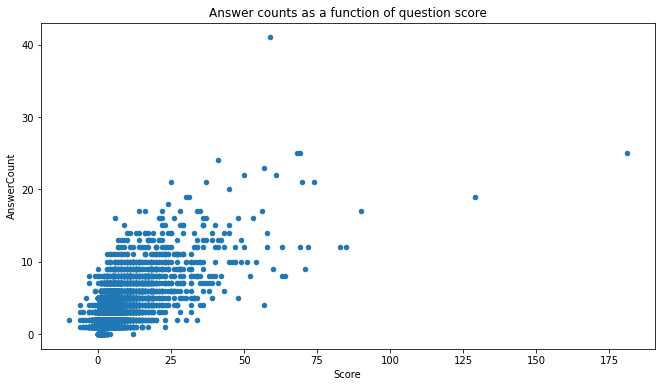

In [32]:
scatter = df[df['is_question']][['Score', 'AnswerCount']].plot(x='Score', y='AnswerCount', kind='scatter', figsize=(11, 6))
ax.set_xlabel('Score')
ax.set_ylabel('Num answers')
scatter.set_title('Answer counts as a function of question score');

Scores and number of answers seem correlated. We mentioned above making the score into a binary label by using `is_score_above_median` as the label. Let's see how this label would correlate with the number of answers by plotting histograms of the numbers of answers a question gets for question in each category (score above and below the median)

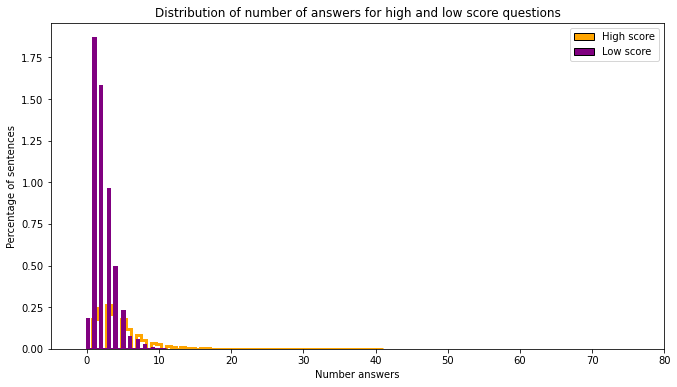

In [33]:
f, ax = plt.subplots(figsize=(11, 6))
ax.set_title('Distribution of number of answers for high and low score questions')
plt.xlim(-5, 80)

ax = df[df['is_question'] & 
       (df['Score'] > df['Score'].median())]['AnswerCount'].hist(bins=60,
                                                                density=True,
                                                                histtype='step',
                                                                color='orange',
                                                                linewidth=3,
                                                                grid=False,
                                                                figsize=(11, 6))
df[df['is_question'] &
  ~(df['Score'] > df['Score'].median())]['AnswerCount'].hist(bins=60,
                                                            density=True,
                                                            histtype='step',
                                                            color='purple',
                                                            linewidth=3,
                                                            grid=False)

handles = [Rectangle((0, 0), 1, 1, color=c, ec='k') for c in ['orange', 'purple']]
labels = ['High score', 'Low score']
plt.legend(handles, labels)
ax.set_xlabel('Number answers')
ax.set_ylabel('Percentage of sentences');

It seems questions that get a high score get more answers. The score of a question thus seems like a good initial label since it is more granular, but the number of answers would be a good choice as well.

While it would make a good label, we cannot use the number of answers as a feature. This is because despite being correlated with the score, we will not have access to it at inference time, when we receive input from the users.